# Pengembangan Aplikasi Prediksi Output Daya pada Pembangkit Listrik Tenaga Gas dan Uap (PLTGU) Berdasarkan Faktor Lingkungan Menggunakan Algoritma Gradient Boosting Regression Berbasis Machine Learning

# Business Understanding

### 💼 Latar Belakang Bisnis

Pembangkit Listrik Siklus Gabungan (Combined Cycle Power Plant / CCPP) merupakan sistem pembangkitan energi yang menggabungkan turbin gas dan turbin uap untuk meningkatkan efisiensi produksi daya listrik. Efisiensi output daya pada CCPP sangat dipengaruhi oleh kondisi lingkungan seperti:
Variabel pada Dataset:
Fitur (Input):
- Temperature (T) — suhu ambient rata-rata per jam (°C)
- Ambient Pressure (AP) — tekanan atmosfer ambient rata-rata per jam (hPa)
- Relative Humidity (RH) — kelembaban relatif rata-rata per jam (%)
- Exhaust Vacuum (V) — vakum buangan dari turbin uap (mmHg)
Target (Output):
- Electrical Energy Output (EP) — energi listrik bersih yang dihasilkan per jam (MW)

Perubahan kecil pada faktor-faktor ini dapat berdampak signifikan pada performa daya listrik yang dihasilkan. Oleh karena itu, diperlukan suatu sistem cerdas yang mampu memprediksi daya output secara akurat berdasarkan data lingkungan aktual.

---

### 🎯 Tujuan Bisnis

- Mengembangkan sistem prediksi daya listrik berbasis Machine Learning dengan algoritma Gradient Boosting Regression.
- Memberikan estimasi output daya secara real-time berdasarkan input kondisi lingkungan.
- Membantu operator dalam pengambilan keputusan dan perencanaan beban operasional.
- Meningkatkan efisiensi dan keandalan operasional pembangkit listrik.

---

### ⚙️ Permasalahan Bisnis

- Operator masih mengandalkan estimasi manual atau rumus baku yang tidak adaptif terhadap dinamika lingkungan.
- Tidak tersedia sistem berbasis data yang dapat memberikan prediksi instan dan akurat terhadap output daya.
- Kurangnya dukungan alat bantu digital yang mudah digunakan oleh operator lapangan.

---

### 📈 Manfaat dan Keuntungan Bisnis

- Meningkatkan efisiensi operasional dan pengaturan distribusi daya.
- Mengurangi risiko pemborosan energi dan biaya akibat over/under load.
- Mendukung transformasi digital pembangkit listrik berbasis teknologi data dan kecerdasan buatan.
- Menyediakan sistem yang dapat diakses secara praktis melalui antarmuka berbasis aplikasi (Streamlit).

---

# Data Understanding

## Import Library

In [98]:
# Data & Visualisasi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Utilitas
from numpy import sqrt
import warnings
warnings.filterwarnings("ignore")

## Data Load

In [99]:
df_old = pd.read_excel('/content/Folds5x2_pp.xlsx')
df_new = pd.read_excel('/content/ccpp_env_2021_2024.xlsx')
print(df_old.info())
print(df_new.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      10000 non-null  float64
 1   V       10000 non-null  float64
 2   AP      10000 non-null  float64
 3   RH      10000 non-null  float64
 4   PE      10000 non-null  float64
dtypes: float64(5)
memory usage: 390.8 KB
None


In [100]:
data = pd.concat([df_old, df_new], ignore_index=True)

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19568 entries, 0 to 19567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      19568 non-null  float64
 1   V       19568 non-null  float64
 2   AP      19568 non-null  float64
 3   RH      19568 non-null  float64
 4   PE      19568 non-null  float64
dtypes: float64(5)
memory usage: 764.5 KB


In [102]:
data.describe()

,AT,V,AP,RH,PE
count,19568.000000,19568.000000,19568.000000,19568.000000,19568.000000
mean,19.622559,54.259735,1013.247429,73.276707,454.426172
std,7.457205,12.691229,5.970263,14.595274,16.802139
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.520000,41.760000,1009.050000,63.230000,439.810000
50%,20.250000,52.050000,1012.920000,74.885000,451.380000
75%,25.760000,66.540000,1017.320000,84.770000,468.374746
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [103]:
data.isnull().sum()

,0
AT,0
V,0
AP,0
RH,0
PE,0


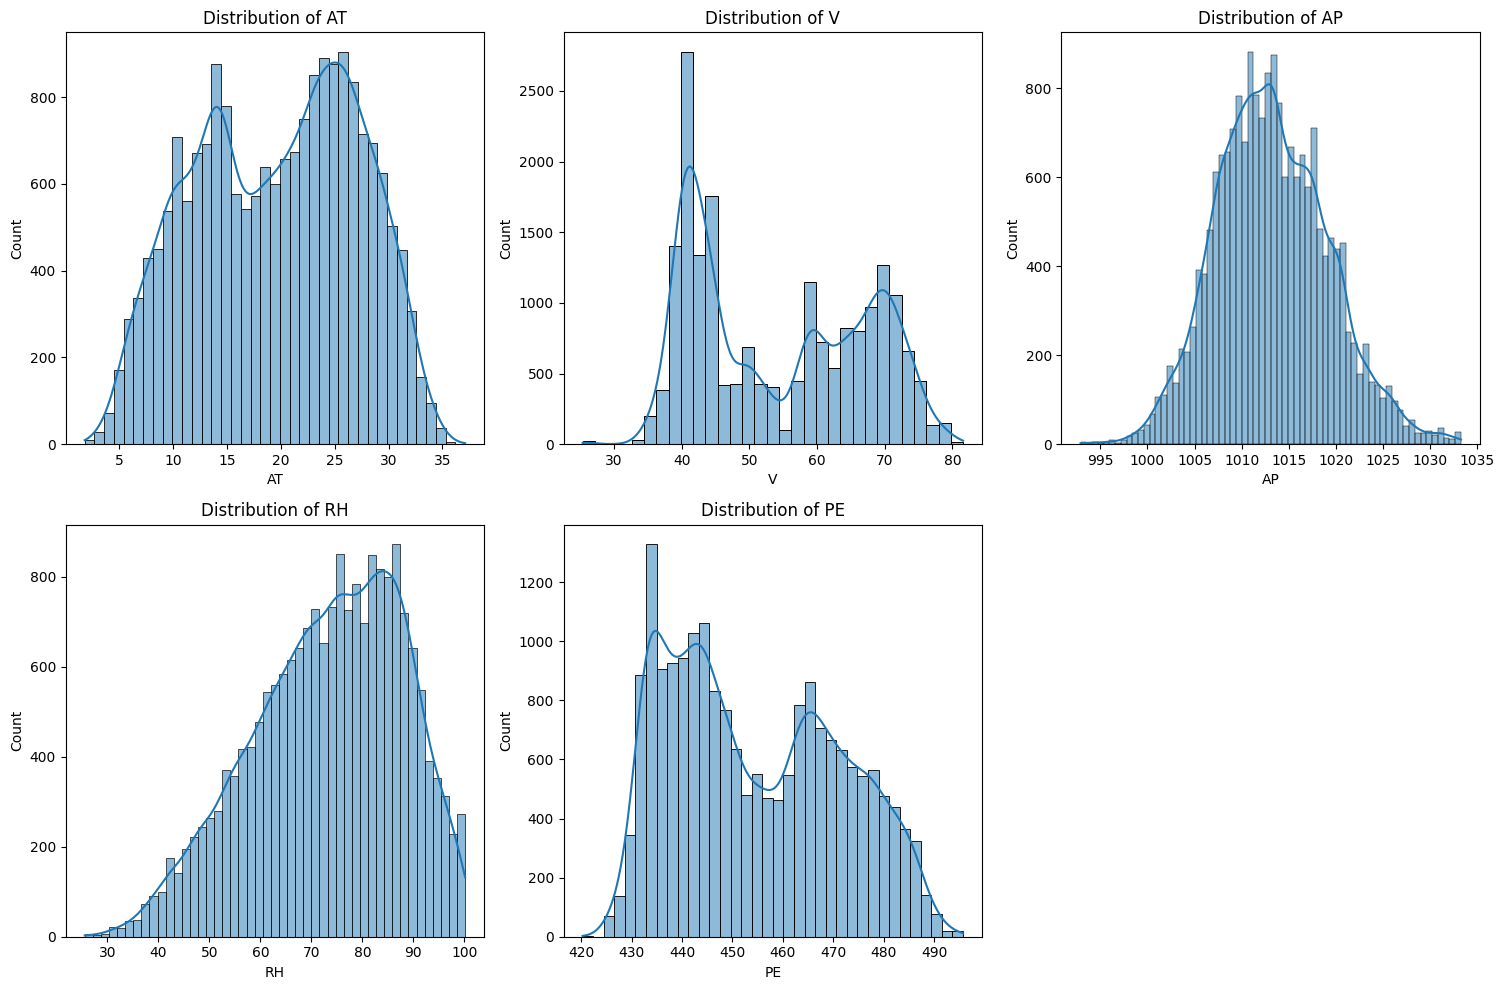

In [104]:
n_features = len(data.columns)
n_cols = 3
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, column in enumerate(data.columns):
    ax = axes[i // n_cols, i % n_cols]
    sns.histplot(data[column], kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}')

for i in range(n_features, n_cols * n_rows):
    fig.delaxes(axes[i // n_cols, i % n_cols])

plt.tight_layout()
plt.show()

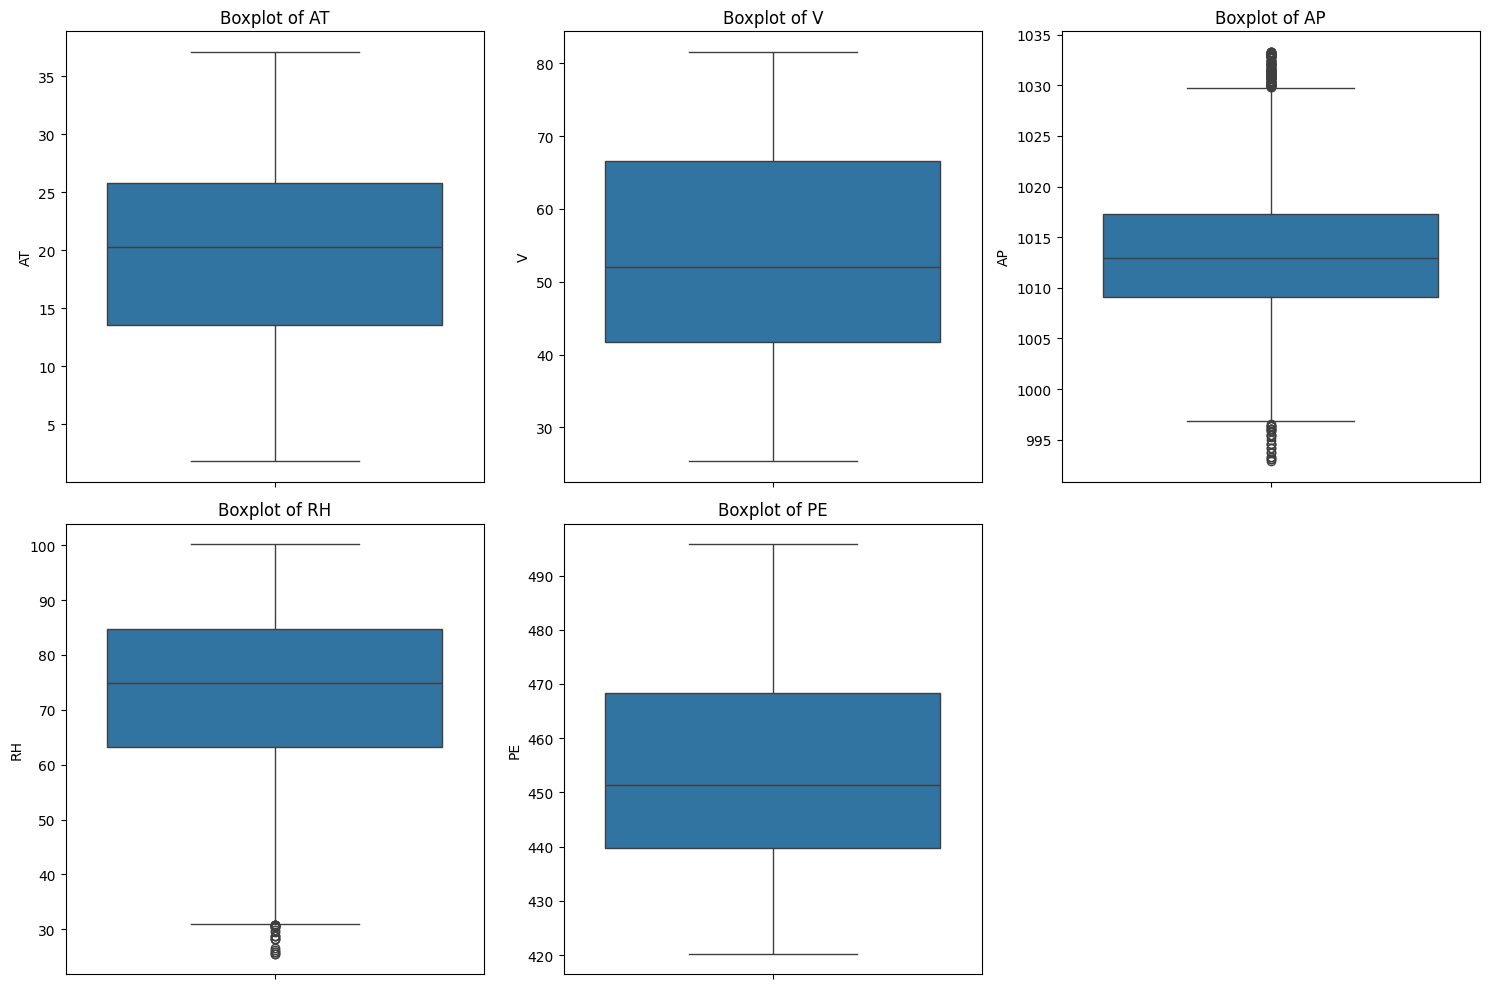

In [105]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, column in enumerate(data.columns):
    ax = axes[i // n_cols, i % n_cols]
    sns.boxplot(data[column], ax=ax)
    ax.set_title(f'Boxplot of {column}')

for i in range(n_features, n_cols * n_rows):
    fig.delaxes(axes[i // n_cols, i % n_cols])

plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

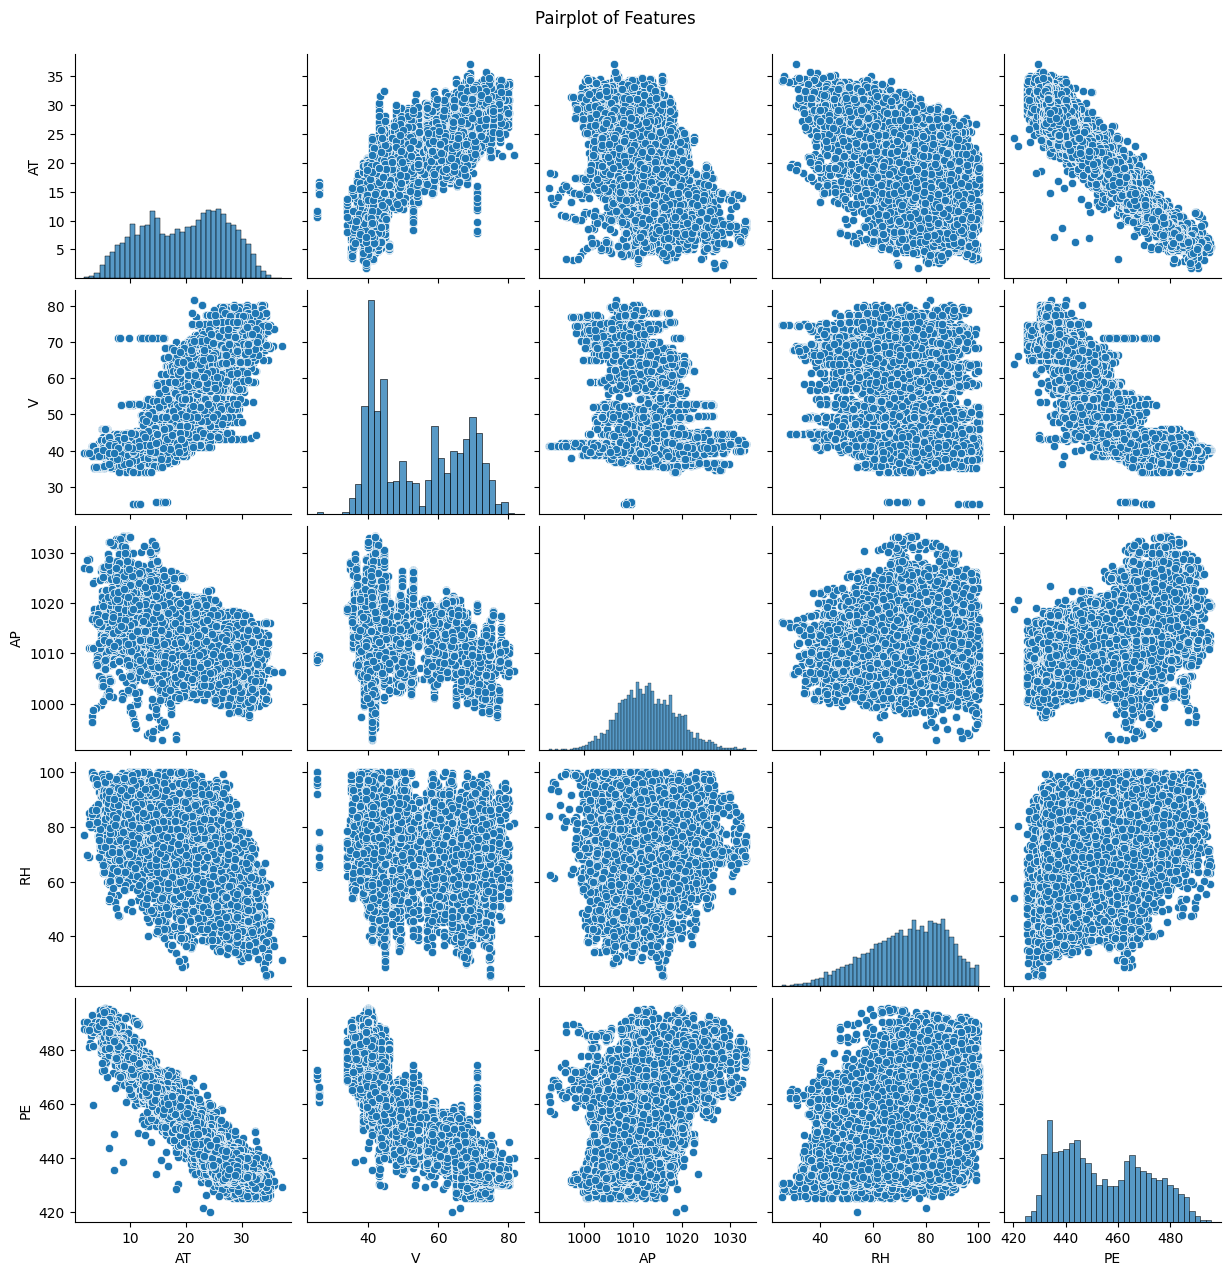

In [106]:
plt.figure(figsize=(10, 8))
sns.pairplot(data)
plt.suptitle('Pairplot of Features', y=1.02)
plt.show()

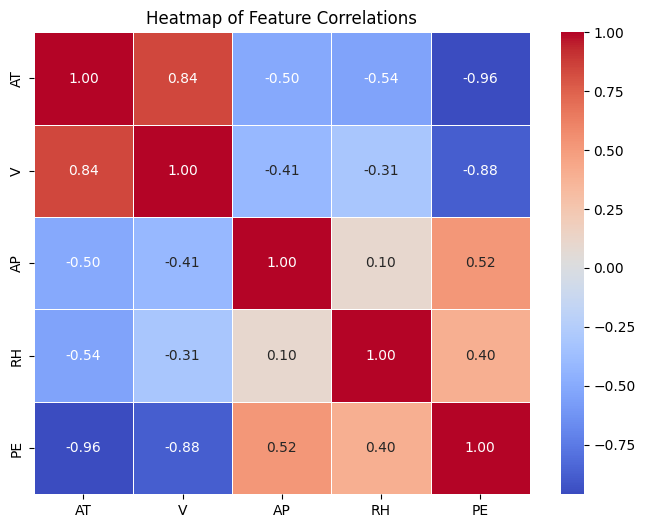

In [107]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

## Data Prepocessing

In [108]:
duplikat = data.duplicated()
print("Jumlah duplikat:", duplikat.sum())

data[duplikat | data.duplicated(keep=False)]

Jumlah duplikat: 3888


,AT,V,AP,RH,PE
231,26.85,75.60,1017.43,74.55,433.480000
345,12.19,41.17,1019.43,65.47,475.640000
352,25.56,75.60,1017.37,69.31,442.200000
468,25.21,75.60,1017.19,69.84,445.840000
726,28.41,75.60,1018.48,56.07,440.280000
...,...,...,...,...,...
19560,16.73,54.30,1017.96,59.44,460.265766
19562,27.14,64.27,1012.71,54.40,442.657750
19563,19.09,43.14,1012.34,45.75,462.284869
19564,12.71,43.80,1023.15,71.16,470.418426


In [109]:
data = data.drop_duplicates()

jumlah_duplikat = data.duplicated().sum()
print(f"Jumlah duplikat setelah dihapus: {jumlah_duplikat}")

Jumlah duplikat setelah dihapus: 0


In [111]:
def iqr_outliers(data):
    outliers = pd.DataFrame()
    for col in data.select_dtypes(include=[np.number]).columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = ((data[col] < lower_bound) | (data[col] > upper_bound)).astype(int)
    return outliers

def cap_outliers(data, col):
    data = data.copy()
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
    return data

data = cap_outliers(data, 'AP')
data = cap_outliers(data, 'RH')

print("Outliers after capping (IQR):")
print(iqr_outliers(data).sum())

Outliers after capping (IQR):
AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64


In [112]:
data.shape

(15680, 5)

In [113]:
X = data[['AT','V','AP','RH']]
y = data['PE']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12544, 4)
X_test shape: (3136, 4)
y_train shape: (12544,)
y_test shape: (3136,)


# Modelling

In [115]:
# === Inisialisasi Model dengan Best Hyperparameters GridSearch ===
gb_model = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=2,
    min_samples_leaf=1,
    n_estimators=300,
    random_state=42
)

# === Latih Model ===
gb_model.fit(X_train, y_train)

# === Prediksi ===
y_pred_gb = gb_model.predict(X_test)

# EVALUATION

In [116]:
# === Evaluasi Model pada Test Set ===
mae_test = mean_absolute_error(y_test, y_pred_gb)
rmse_test = sqrt(mean_squared_error(y_test, y_pred_gb))
r2_test = r2_score(y_test, y_pred_gb)

print("=== Evaluation on Test Set ===")
print(f"MAE  : {mae_test:.2f} MW")
print(f"RMSE : {rmse_test:.2f} MW")
print(f"R²   : {r2_test:.4f}")

# === Evaluasi dengan Cross-Validation (5-Fold) ===
gb_cv_scores = -cross_val_score(
    gb_model, X, y,
    cv=5,
    scoring='neg_mean_absolute_error'
)
cv_mae_mean = gb_cv_scores.mean()
cv_mae_std = gb_cv_scores.std()

print("\n=== Cross-Validation (5-Fold) ===")
print(f"CV MAE: {cv_mae_mean:.2f} ± {cv_mae_std:.2f} MW")

=== Evaluation on Test Set ===
MAE  : 2.10 MW
RMSE : 3.00 MW
R²   : 0.9669

=== Cross-Validation (5-Fold) ===
CV MAE: 2.26 ± 0.34 MW


In [117]:
df_perbandingan = pd.DataFrame({
    'Data Asli (y_test)': y_test.values,
    'Hasil Prediksi (y_pred)': y_pred_gb
})

print(df_perbandingan.head(10))

   Data Asli (y_test)  Hasil Prediksi (y_pred)
0          444.660000               450.056994
1          476.410000               474.666587
2          482.970000               485.375751
3          479.220000               475.219890
4          473.110000               472.936621
5          432.952097               434.100553
6          447.060000               444.241701
7          428.270000               430.338886
8          458.870000               462.114732
9          472.500000               472.213375


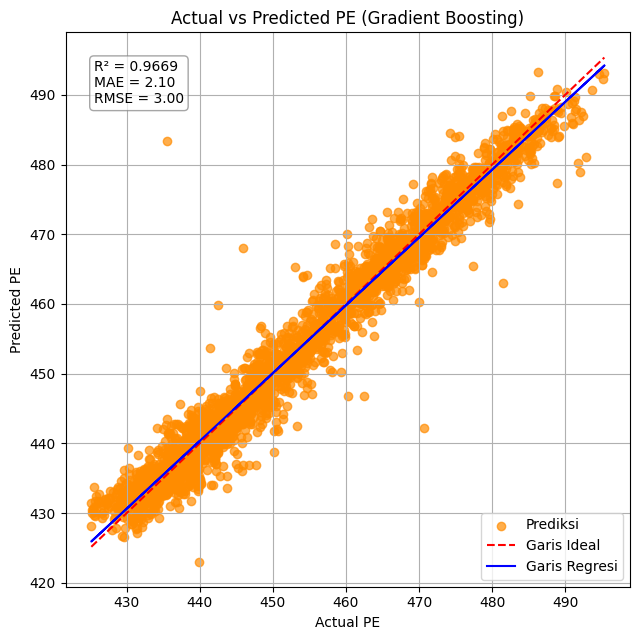

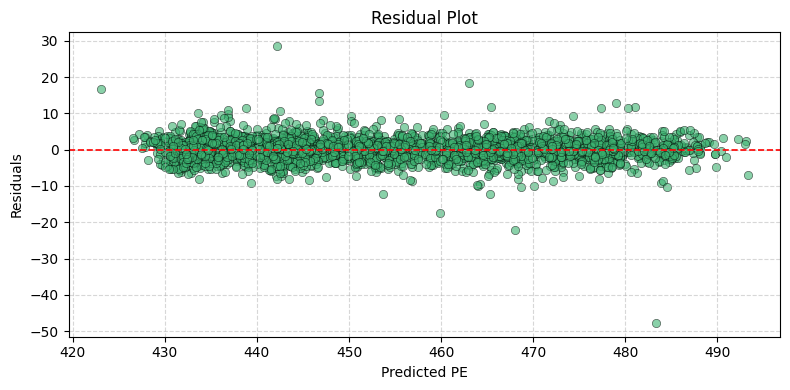

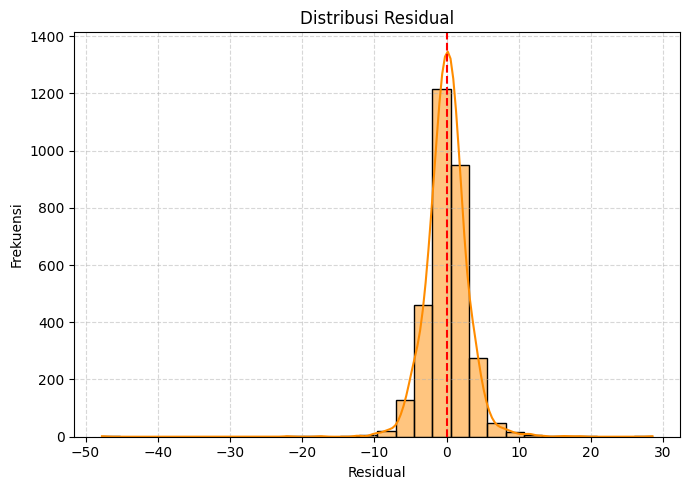

In [118]:
r2 = r2_score(y_test, y_pred_gb)
mae = mean_absolute_error(y_test, y_pred_gb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))

# === Plot: Prediksi vs Aktual dengan Garis Regresi dan Metrik ===
plt.figure(figsize=(6.5, 6.5))
plt.scatter(y_test, y_pred_gb, alpha=0.7, color='darkorange', label='Prediksi')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Garis Ideal')

coef = np.polyfit(y_test, y_pred_gb, 1)
reg_line = np.poly1d(coef)
plt.plot(y_test, reg_line(y_test), color='blue', linestyle='-', label='Garis Regresi')

plt.xlabel("Actual PE")
plt.ylabel("Predicted PE")
plt.title("Actual vs Predicted PE (Gradient Boosting)")

plt.text(
    0.05, 0.95,
    f"R² = {r2:.4f}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.7)
)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Residual Plot (Residual vs Prediksi) ===
residuals = y_test - y_pred_gb

plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred_gb, y=residuals, color='mediumseagreen', edgecolor='black', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1.2)
plt.xlabel('Predicted PE')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === Distribusi Residual (Histogram + KDE) ===
plt.figure(figsize=(7, 5))
sns.histplot(residuals, bins=30, kde=True, color='darkorange')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribusi Residual')
plt.xlabel('Residual')
plt.ylabel('Frekuensi')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [121]:
import joblib
joblib.dump(gb_model, "model_gradient_boosting.pkl")

['model_gradient_boosting.pkl']

In [120]:
# Simpan X_test ke file CSV
X_test.to_csv("X_test.csv", index=False)

# Simpan y_test ke file CSV
y_test.to_csv("y_test.csv", index=False)